## Construction d'un premier modèle

Dans ce *Notebook*, nous construisons un premier modèle de prédiction des cas de Dengue.

In [1]:
# Load pyspark
import findspark

findspark.init()

#import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

import datetime

import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

spark = SparkSession.builder.appName("dengue").getOrCreate()

### Chargement des données pré-traitées

In [2]:
df_train = spark.read.parquet("data/01-preprocessed")

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train = (1456, 24)


### Construction des jeux d'entrainement et de test

In [3]:
# San Juan (sj)
df_train_sj = df_train.filter(df_train.city == 'sj')
min_date_sj, max_date_sj = df_train_sj.select(F.min("week_start_date"),
                                              F.max("week_start_date")).first()

print("San Juan data:")
print("df_train_sj = ({}, {})".format(df_train_sj.count(), len(df_train_sj.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_sj, max_date_sj))

# Iquitos (iq)
df_train_iq = df_train.filter(df_train.city == 'iq')
min_date_iq, max_date_iq = df_train_iq.select(F.min("week_start_date"),
                                              F.max("week_start_date")).first()

print("Iquitos data:")
print("df_train_iq = ({}, {})".format(df_train_iq.count(), len(df_train_iq.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_iq, max_date_iq))

San Juan data:
df_train_sj = (936, 24)
	date_start = 1990-04-30 / date_stop = 2008-04-22
Iquitos data:
df_train_iq = (520, 24)
	date_start = 2000-07-01 / date_stop = 2010-06-25


In [9]:
# split train (90%) and test (10%)

# San Juan (sj)
testsize_sj = int(0.1 * df_train_sj.count())
delta_sj = datetime.timedelta(weeks=testsize_sj)
cut_date_sj = max_date_sj - delta_sj

train_sj = df_train_sj.filter(df_train_sj.week_start_date <= cut_date_sj)
test_sj = df_train_sj.filter(df_train_sj.week_start_date > cut_date_sj)

print("train_sj = ({}, {})".format(train_sj.count(), len(train_sj.columns)))
print("test_sj = ({}, {})".format(test_sj.count(), len(test_sj.columns)))

# Iquitos (iq)
testsize_iq = int(0.1 * df_train_iq.count())
delta_iq = datetime.timedelta(weeks=testsize_iq)
cut_date_iq = max_date_iq - delta_iq

train_iq = df_train_iq.filter(df_train_iq.week_start_date <= cut_date_iq)
test_iq = df_train_iq.filter(df_train_iq.week_start_date > cut_date_iq)

print("train_iq = ({}, {})".format(train_iq.count(), len(train_iq.columns)))
print("test_iq = ({}, {})".format(test_iq.count(), len(test_iq.columns)))

train_sj = (843, 24)
test_sj = (93, 24)
train_iq = (468, 24)
test_iq = (52, 24)


In [10]:
# concatanate the 2 sets
train = train_sj.union(train_iq)
test = test_sj.union(test_iq)

print("train = ({}, {})".format(train.count(), len(train.columns)))
print("test = ({}, {})".format(test.count(), len(test.columns)))

train = (1311, 24)
test = (145, 24)


### Affichage des jeux de données

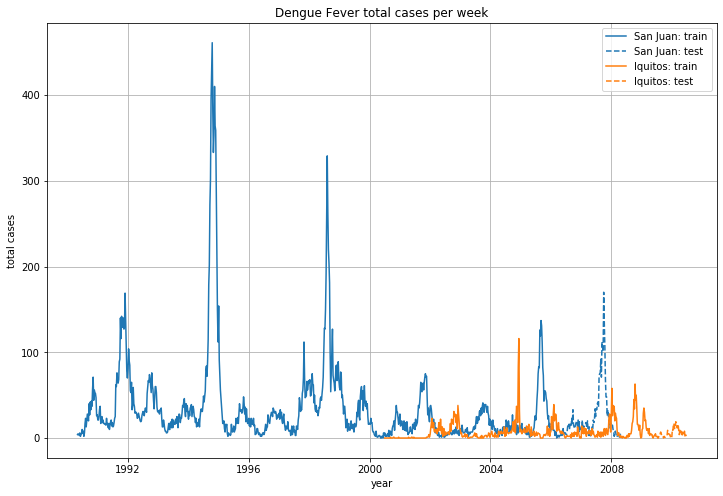

In [11]:
pd_train_sj = train_sj.toPandas()
pd_train_iq = train_iq.toPandas()

pd_test_sj = test_sj.toPandas()
pd_test_iq = test_iq.toPandas()

# Total cases per city
plt.figure(figsize=(12, 8))

plt.grid()
plt.title('Dengue Fever total cases per week')

plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

p_sj = plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'],
                label='San Juan: train', linestyle='solid')
plt.plot(pd_test_sj['week_start_date'], pd_test_sj['total_cases'], label='San Juan: test',
         linestyle='dashed', color=p_sj[0].get_color())

p_iq = plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'],
                label='Iquitos: train', linestyle='solid')
plt.plot(pd_test_iq['week_start_date'], pd_test_iq['total_cases'], label='Iquitos: test',
         linestyle='dashed', color=p_iq[0].get_color())

plt.legend()

plt.show()

### Construction du *pipeline*

In [12]:
# OneHotEncoder categorial variables
indexer = StringIndexer(inputCol='city', outputCol='city_')
encoder = OneHotEncoder(inputCol='city_', outputCol='cityVect')

# Build feature vector (taking all variables)
vectorAssembler = VectorAssembler(
    inputCols=['cityVect',
               'year', 'weekofyear',
               'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
               'reanalysis_precip_amt_kg_per_m2',
               'reanalysis_relative_humidity_percent',
               'reanalysis_sat_precip_amt_mm',
               'reanalysis_specific_humidity_g_per_kg',
               'station_avg_temp_c',
               'station_diur_temp_rng_c',
               'station_max_temp_c', 'station_min_temp_c', 
               'station_precip_mm',  
               'reanalysis_air_temp_c',
               'reanalysis_avg_temp_c',
               'reanalysis_dew_point_temp_c',
               'reanalysis_max_air_temp_c',
               'reanalysis_min_air_temp_c',
               'reanalysis_tdtr_c',
               ], 
    outputCol = 'features')

# scaler
scaler = StandardScaler(inputCol='features',
                        outputCol='scaled_features',
                        withStd=True, withMean=True)

# linear regression
lr = LinearRegression(featuresCol='scaled_features',
                      labelCol='total_cases',
                      predictionCol='lr_prediction')

# Random forest
rf = RandomForestRegressor(featuresCol='scaled_features',
                           labelCol='total_cases',
                           predictionCol='rf_prediction')

### 2. Random Forest

#### 2.1 Simple

In [13]:
pipeline_rf = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, rf])

evaluator_rf = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   metricName="mae")

# build model
model_rf = pipeline_rf.fit(train)

# Build prediction from 'test' dataset
pred_rf = model_rf.transform(test)

pred_rf.select(['total_cases','rf_prediction']).show(52)

mae = evaluator_rf.evaluate(pred_rf)

print("Random Forest::Before grid search - MAE = {:.3f}".format(mae))

+-----------+------------------+
|total_cases|     rf_prediction|
+-----------+------------------+
|          8| 29.75473988366706|
|         14| 16.81367144214191|
|         12|26.949072651535744|
|         16|32.374010038497076|
|         10|25.918720678161094|
|         16| 36.58886488848312|
|         18|36.486161937776686|
|         15| 43.86621523322974|
|         23|40.616125633344545|
|         17| 50.77657981716139|
|         33|42.451906323939156|
|         15| 50.77964880892235|
|         13|41.422774945101025|
|         11| 27.83185633107208|
|         14| 34.92245821975141|
|         17| 33.27445573813672|
|         19| 63.41800209861721|
|         20| 37.90358947081456|
|         12|26.346643995671677|
|         21|23.092774994515445|
|          7|30.299829939077654|
|         19| 24.81941356862359|
|         10| 26.54138876025835|
|         13|24.484706608916632|
|         10|17.791079081819863|
|          8|17.500876015518717|
|         21|13.643707993648187|
|         

#### Grid search

In [ ]:
#numTrees = [15, 20, 25, 30, 40, 50, 60]
numTrees = [30, 35, 40, 45, 50, 55]
#maxDepths = [2, 4, 5, 7, 10, 15, 20]
maxDepths = [3, 4, 5, 6, 7, 8]

evaluator_rf = RegressionEvaluator(labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   metricName="mae")

rf_bestModel = model_rf
best_mae = mae

for nTree in numTrees:
    for depth in maxDepths:

        rf = RandomForestRegressor(featuresCol='scaled_features',
                                   labelCol='total_cases',
                                   predictionCol='rf_prediction',
                                   numTrees=nTree,
                                   maxDepth=depth)

        pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, rf])

        # build model
        model = pipeline.fit(train)

        # Build prediction from 'test' dataset
        pred = model.transform(test)

        mae = evaluator_rf.evaluate(pred)
        if mae < best_mae:
            best_mae = mae
            rf_bestModel = model

pred_rf = rf_bestModel.transform(test)

mae = evaluator_rf.evaluate(pred_rf)

numTree = rf_bestModel.stages[-1].getNumTrees
maxDepth = rf_bestModel.stages[-1]._java_obj.getMaxDepth()

print("Best model (numTree={}, MaxDepth={}) => MAE = {:.3f}".format(numTree, maxDepth, mae))

#### plot

In [ ]:
# create pandas dataframe from spark dataframe
pd_pred_rf = pred_rf.toPandas()

pd_pred_rf_sj = pd_pred_rf[pd_pred_rf['city'] == 'sj']
pd_pred_rf_iq = pd_pred_rf[pd_pred_rf['city'] == 'iq']

In [ ]:
# Total cases per city
plt.figure(figsize=(12, 8))
plt.grid()
plt.title('Random Forest: Prediction Dengue Fever total cases per week')


plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'], label='San Juan')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'], label='Iquitos')

plt.plot(pd_pred_rf_sj['week_start_date'], pd_pred_rf_sj['total_cases'], label='Target: San Juan')
plt.plot(pd_pred_rf_iq['week_start_date'], pd_pred_rf_iq['total_cases'], label='Target: Iquitos')

plt.plot(pd_pred_rf_sj['week_start_date'], pd_pred_rf_sj['rf_prediction'], label='Pred: San Juan')
plt.plot(pd_pred_rf_iq['week_start_date'], pd_pred_rf_iq['rf_prediction'], label='Pred: Iquitos')

plt.legend()

plt.show()

In [ ]:
# zoom

# Total cases per city
plt.figure(figsize=(15, 6))

# San Juan
ax1 = plt.subplot(2, 2, 1)
plt.grid()

plt.title('San Juan: Dengue Fever total cases per week')
plt.xlabel('year')
plt.ylabel('total cases')

plt.plot(pd_pred_rf_sj['week_start_date'], pd_pred_rf_sj['total_cases'],
         label='Target')
plt.plot(pd_pred_rf_sj['week_start_date'], pd_pred_rf_sj['rf_prediction'],
         label='Predictions')

plt.legend()

# Iquitos
ax2 = plt.subplot(2, 2, 2)
plt.grid()

plt.title('Iquitos: Dengue Fever total cases per week')
plt.xlabel('year')
plt.ylabel('total cases')

plt.plot(pd_pred_rf_iq['week_start_date'], pd_pred_rf_iq['total_cases'],
         label='Target')
plt.plot(pd_pred_rf_iq['week_start_date'], pd_pred_rf_iq['rf_prediction'],
         label='Predictions')

plt.legend()

plt.show()

### Premier "*Benchmark*"



In [ ]:
# df_bench

# load data
df_bench = spark.read.parquet("data/01-benchmark")

# display information
print("df_bench = ({}, {})".format(df_bench.count(), len(df_bench.columns)))

df_bench.printSchema()

In [ ]:
# df_train

# display information
print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train.printSchema()

In [ ]:
# OneHotEncoder categorial variables
indexer = StringIndexer(inputCol='city', outputCol='city_')
encoder = OneHotEncoder(inputCol='city_', outputCol='cityVect')

# Build feature vector
vectorAssembler = VectorAssembler(
    inputCols=['cityVect',
               'year', 'weekofyear',
               'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
               'reanalysis_precip_amt_kg_per_m2',
               'reanalysis_relative_humidity_percent',
               'reanalysis_sat_precip_amt_mm',
               'reanalysis_specific_humidity_g_per_kg',
               'station_avg_temp_c',
               'station_diur_temp_rng_c',
               'station_max_temp_c', 'station_min_temp_c', 
               'station_precip_mm',  
               'reanalysis_air_temp_c',
               'reanalysis_avg_temp_c',
               'reanalysis_dew_point_temp_c',
               'reanalysis_max_air_temp_c',
               'reanalysis_min_air_temp_c',
               'reanalysis_tdtr_c',
               ], 
    outputCol = 'features')

# scaler
scaler = StandardScaler(inputCol='features',
                        outputCol='scaled_features',
                        withStd=True, withMean=True)


# Make predictions
pipeline = Pipeline(stages=[indexer, encoder, vectorAssembler, scaler, rf_bestModel])

# build model
model = pipeline.fit(df_train)

In [ ]:
# Build prediction from 'test' dataset
pred_bench = model.transform(df_bench)


df_out = pred_bench['city', 'year', 'weekofyear', 'rf_prediction']
df_out = df_out.withColumn('total_cases', df_out['rf_prediction'].cast('int'))
df_out = df_out.drop('rf_prediction')

df_out.write.csv('data/01-submission.csv')